In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter(action='ignore')

### LSTM Skorch example

In [34]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from skorch import NeuralNetRegressor
import torch.nn as nn
import torch
from icecream import ic

X_regr, y_regr = make_regression(
    1000,
    20,
    n_informative=10,
    random_state=0
)
X_regr = X_regr.astype(np.float32)
y_regr = y_regr.astype(np.float32)/100
y_regr = y_regr.reshape(-1,1)
ni, no, nh, nlayers = 20, 1, 10, 3

In [44]:
class LSTM(nn.Module):
    def __init__(self,ni=6,no=3,nh=10,nlayers=1):
        super(LSTM,self).__init__()
        self.ni = ni
        self.no = no
        self.nh = nh
        self.nlayers = nlayers
        self.lstms = nn.ModuleList(
            [nn.LSTMCell(self.ni,self.nh)]+[nn.LSTMCell(self.nh,self.nh) for i in range(nlayers-1)]
        )
        self.out = nn.Linear(self.nh,self.no)
        self.do = nn.Dropout(p=0.2)
        self.activation_function = nn.Tanh()
        self.dtype = torch.float
    def forward(self,x,h0=None,train=False):
        hs = x # initiate hidden state
        if h0 is None:
            h = torch.zeros(hs.shape[0],self.nh,device=x.device)
            c = torch.zeros(hs.shape[0],self.nh,device=x.device)
        else:
            (h,c) = h0
        # LSTM cells
        for i in range(self.nlayers):
            h, c = self.lstms[i](hs, (h,c))
            if train:
                hs = self.do(h)
            else:
                hs = h
        y = self.out(hs)
        return y, (h,c)

class ContextlessMSE(nn.MSELoss):
    def forward(self,y_pred,y_true):
        y, (h,c) = y_pred # extract prediction and context information
        return super().forward(y,y_true)

lstm_regressor = NeuralNetRegressor(
    module=LSTM, 
    module__ni=ni,
    module__no=no,
    module__nh=nh,
    module__nlayers=nlayers,
    max_epochs=20,
    lr=0.1,
    criterion=ContextlessMSE
)

In [45]:
lstm_regressor_pipeline = Pipeline([('lstm',lstm_regressor)])
lstm_regressor_pipeline.fit(X_regr,y_regr)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        4.7202        4.0712  0.0222
      2        4.6817        4.0438  0.0283
      3        4.6543        4.0213  0.0255
      4        4.6274        3.9967  0.0322
      5        4.5950        3.9648  0.0206
      6        4.5500        3.9174  0.0286
      7        4.4792        3.8385  0.0384
      8        4.3555        3.6909  0.0322
      9        4.1121        3.3738  0.0350
     10        3.5666        2.6097  0.0240
     11        2.3671        1.2702  0.0303
     12        1.0404        0.6253  0.0251
     13        0.6314        0.5236  0.0295
     14        0.5443        0.4820  0.0309
     15        0.4885        0.4523  0.0461
     16        0.4408        0.4340  0.0302
     17        0.4015        0.4155  0.0285
     18        0.3717        0.3600  0.0285
     19        0.3291        0.3247  0.0271
     20        0.3039        0.2730  0.0320


Pipeline(steps=[('lstm',
                 <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=LSTM(
    (lstms): ModuleList(
      (0): LSTMCell(20, 10)
      (1): LSTMCell(10, 10)
      (2): LSTMCell(10, 10)
    )
    (out): Linear(in_features=10, out_features=1, bias=True)
    (do): Dropout(p=0.2, inplace=False)
    (activation_function): Tanh()
  ),
))])

In [52]:
# lstm_regressor_pipeline.named_steps['lstm'].get_params()
y_pred = lstm_regressor_pipeline.predict(X_regr[:5])
ic(y_pred);

ic| y_pred: array([[ 0.44321513],
                   [-1.9767034 ],
                   [-0.13864079],
                   [-0.6392553 ],
                   [-0.70358443]], dtype=float32)


### Real Data LSTM Example

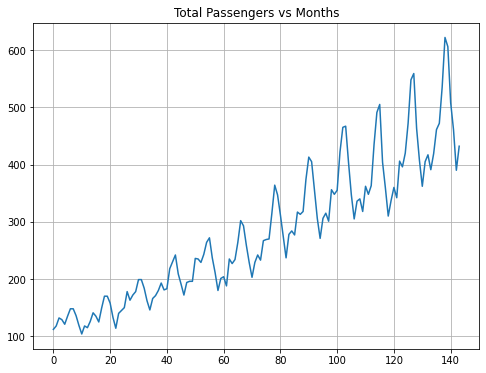

In [58]:
import pandas as pd
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt

flights_df = sns.load_dataset("flights")
plt.figure(figsize=(8,6))
plt.plot(flights_df.passengers)
plt.title("Total Passengers vs Months")
plt.grid(True)
plt.show();

In [69]:
test_data_size = 12
all_data = flights_df['passengers'].values.astype(np.float32)
train_data, test_data = all_data[:-test_data_size], all_data[-test_data_size:]

def create_sequences(data, seq_length):
    x_list, y_list = [], []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[(i+seq_length):(i+seq_length+1)]
        x_list.append(x)
        y_list.append(y)
    return np.array(x_list), np.array(y_list)

seq_length = 12
X_train, y_train = create_sequences(train_data,seq_length)
X_test, y_test = create_sequences(test_data,seq_length)

In [87]:
class flightLSTM(nn.Module):
    def __init__(self,input_size=12,hidden_layer_size=100,output_size=1):
        super(flightLSTM,self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.hidden = (
                torch.zeros(1,1,self.hidden_layer_size),
                torch.zeros(1,1,self.hidden_layer_size)
            )
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_layer_size
        )
        self.linear = nn.Linear(
            in_features=hidden_layer_size,
            out_features=output_size
        )
    def forward(self,input_seq):
        lstm_out, self.hidden = self.lstm(input_seq.view(len(input_seq),1,-1),self.hidden)
        preds = self.linear(lstm_out.view(len(input_seq),-1))
        y_pred = preds[-1]
        return y_pred

class flightMSE(nn.MSELoss):
    def forward(self,y,y_true):
        y_pred = y # extract prediction and context information
        return super().forward(y_pred,y_true)


flight_lstm_regressor = NeuralNetRegressor(
    module=flightLSTM,
    module__input_size=seq_length,
    module__hidden_layer_size=100,
    module__output_size=1,
    max_epochs=20,
    lr=0.001,
    criterion=flightMSE
)

flight_lstm_regressor_pipeline = Pipeline([
    ('scale',MinMaxScaler(feature_range=(-1,1))),
    ('lstm',flight_lstm_regressor)
])

In [88]:
flight_lstm_regressor_pipeline.fit(X_train,y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   101423.6094    24406.5312  0.0227
      2   100660.6328    24346.5605  0.0306
      3    99424.8281    24625.5215  0.0353
      4    96403.5234    25373.4062  0.0304
      5    87101.1406     9300.4062  0.0693
      6    66992.8125     3012.6956  0.0409
      7    47753.0039      660.1666  0.0304
      8    33678.9492     1033.1843  0.0358
      9    24473.6523     2820.0354  0.0373
     10    18581.8926     5199.7690  0.0422
     11    14821.6787     7707.5142  0.0398
     12    12424.1055    10096.8271  0.0501
     13    10895.9932    12250.9072  0.0485
     14     9922.2441    14127.5732  0.0478
     15     9301.8242    15725.6562  0.0613
     16     8906.5596    17064.9941  0.0662
     17     8654.7539    18174.6465  0.0651
     18     8494.3447    19086.1777  0.1089
     19     8392.1602    19830.1953  0.0251
     20     8327.0693    20434.5254  0.0317


Pipeline(steps=[('scale', MinMaxScaler(feature_range=(-1, 1))),
                ('lstm',
                 <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=flightLSTM(
    (lstm): LSTM(12, 100)
    (linear): Linear(in_features=100, out_features=1, bias=True)
  ),
))])